# Random-Forest und diverse andere Modelle durchrechnen #


### Importing the dataset and libraries


we have the data from: https://www.kaggle.com/datasets/dumanmesut/individual-carbon-footprint-calculation/data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

df=pd.read_csv('Carbon_Emission.csv',sep=";")
df.head(3)

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595


### sorting the variable into groups 

In [3]:
#variables_quantitative =df.select_dtypes(include=[np.number]).drop('CarbonEmission',axis=1).columns.tolist()
variables_quantitative = [
    "Monthly Grocery Bill", "Vehicle Monthly Distance Km", 
    "Waste Bag Weekly Count", "How Long TV PC Daily Hour",
    "How Many New Clothes Monthly", "How Long Internet Daily Hour"]             #"CarbonEmission" wäre auch noch eine Zahlenmenge

variables_mit_mehreren_antwortmoeglichkeiten=["Recycling" ,"Cooking_With"]       #Variable mit mehrere Antwortmöglichkeiten

variables_for_one_hot_encoded=['Body Type','Sex','Diet','How Often Shower',
                               'Heating Energy Source','Social Activity',
                               'Frequency of Traveling by Air','Waste Bag Size','Energy efficiency']

variables_transport_vehicle_type=["Transport","Vehicle Type"]                    #Werte aus 2 Spalten in 1 Spalte zusammengeführt

#gibt noch die Spalte "CarbonEmission"


all_columns=set(variables_mit_mehreren_antwortmoeglichkeiten).union(
    variables_transport_vehicle_type,
    variables_quantitative,
    variables_for_one_hot_encoded,
    ["CarbonEmission"])
assert set(df.columns.tolist()).difference(all_columns)==set() #überprüft ob empty-set ist dh ob ich in den obrigen Listen alle Spalten erwähnt habe

### variables "Transport" and "Vehicle Type" (they have combined information)


In [4]:
#variables "Transport" and "Vehicle Type"

##test
#test: if "Transport"=="public transport" then "Vehicle Type"==NaN
assert df[df["Transport"]=="public"]["Vehicle Type"].isna().all()  #wenn in der Liste alle True sind, kommt ein True raus dh stellt sicher das alle true sind #assert tut gar nichts bei True aber bei False macht Fehlermeldung und hört auf

#test: if "walk/bicycle" then "Vehicle Type"==NaN
assert df[df["Transport"]=="walk/bicycle"]["Vehicle Type"].isna().all()  #wenn in der Liste alle True sind, kommt ein True raus dh stellt sicher das alle true sind #assert tut gar nichts bei True aber bei False macht Fehlermeldung und hört auf

#test: if "Transport"=="private" then "Vehicle Type"!=NaN
assert not ((df["Transport"]=="private") & (df["Vehicle Type"].isna())).any() #any weil gibt es irgendein True? False heißt es gibt kein einziges True


##create new column: 
df["Transport Vehicle Type"]=df["Vehicle Type"] #definiere neue Spalte
df.loc[df["Transport Vehicle Type"].isna(), "Transport Vehicle Type"] = df["Transport"] # Werte aus 'Transport' übernehmen, wenn 'Vehicle Type' NaN ist
#df[["Transport","Vehicle Type","Transport Vehicle Type"]]



##add variable to one-hot-encoding
if "Transport Vehicle Type" not in variables_for_one_hot_encoded: ##wenn es noch nicht hinzugefügt wurde bzw is one element in the list already?
    variables_for_one_hot_encoded.append("Transport Vehicle Type") 

##veranschaulichen der neuen Spalten und ihrer Werte

df[["Transport","Vehicle Type","Transport Vehicle Type"]]


,Transport,Vehicle Type,Transport Vehicle Type
0,public,NaN,public
1,walk/bicycle,NaN,walk/bicycle
2,private,petrol,petrol
3,walk/bicycle,NaN,walk/bicycle
4,private,diesel,diesel
...,...,...,...
9995,private,hybrid,hybrid
9996,private,lpg,lpg
9997,walk/bicycle,NaN,walk/bicycle
9998,private,petrol,petrol


### variables "Recycling" and "Cooking_With" (these variables allow multiple answers)

In [5]:
##create new column: 
unique_values_Recycling= set([item for sublist in df['Recycling'].unique() for item in eval(sublist)]) # Liste aller einzigartigen Recycling-Möglichkeiten
# Für jede einzigartige Recycling-Möglichkeit eine neue Spalte hinzufügen und mit 0 oder 1 füllen
for item in unique_values_Recycling:
    df['Recycling '+str(item)] = df['Recycling'].apply(lambda x: 1 if item in x else 0)

##create new column: 
unique_values_cooking_With= set([item for sublist in df['Cooking_With'].unique() for item in eval(sublist)]) # Liste aller einzigartigen Cooking_With-Möglichkeiten
# Für jede einzigartige Cooking_With-Möglichkeit eine neue Spalte hinzufügen und mit 0 oder 1 füllen
for item in unique_values_cooking_With:
    df['Cooking With '+str(item)] = df['Cooking_With'].apply(lambda x: 1 if item in x else 0)



##add column to variables_quantitative for lineare Regression
columns_recycling=['Recycling '+str(item) for item in unique_values_Recycling] #liste mit Spalten-Namen
if columns_recycling[0] not in variables_quantitative: ##wenn es noch nicht hinzugefügt wurde bzw is one element in the list already?
    variables_quantitative += columns_recycling
columns_cooking_with=['Cooking With '+str(item) for item in unique_values_cooking_With] #liste mit Spalten-Namen
if columns_cooking_with[0] not in variables_quantitative: ##wenn es noch nicht hinzugefügt wurde bzw is one element in the list already?
    variables_quantitative += columns_cooking_with


#Darstellung 
df.iloc[:, -13:] #prints the last 13 columns
df.iloc[282:284, -13:] #Person 282 cooks with "nothing" deshalb can bei one-hot-encoding nicht eine Spalte gelöscht werden, person 283 who doesn't recycle deshalb can bei one-hot-encoding nicht eine Spalte gelöscht werden


,Recycling,Cooking_With,CarbonEmission,Transport Vehicle Type,Recycling Paper,Recycling Plastic,Recycling Metal,Recycling Glass,Cooking With Stove,Cooking With Airfryer,Cooking With Oven,Cooking With Grill,Cooking With Microwave
282,"['Paper', 'Plastic', 'Metal']",[],1484,public,1,1,1,0,0,0,0,0,0
283,[],"['Stove', 'Grill', 'Airfryer']",2955,public,0,0,0,0,1,1,0,1,0


### One-Hot-Encoding for categorical variables

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df[variables_quantitative + variables_for_one_hot_encoded]   #Ziel: every column except "CarbonEmission"

# Create the ColumnTransformer using the list "variables_for_one_hot_encoded"
cf = ColumnTransformer(
    [(col, OneHotEncoder(drop="first"), [col]) for col in variables_for_one_hot_encoded],  
    remainder="passthrough")   

cf.fit(X)
X_transformed = cf.transform(X)


### linear Regression


In [7]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

y = df["CarbonEmission"]

scores = []
for i in range(10):
    ##Splitting the dataset into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_transformed,y, train_size = 0.75)

    ##Implementing the linear model
    model = LinearRegression()
    model.fit(X_train, y_train)

    ##Evaluating the Model
    scores.append(model.score(X_test, y_test))

print("average R-squared score (from test-set):",np.mean(scores))

average R-squared score (from test-set): 0.9352958640836302


### Prediction/Estimation of the Carbon Emission of a random person


In [8]:
#Daten nicht manuell eingegeben sondern aus dem Data-Frame übernommen
X_pred= df.loc[0:1] #first 2 persons
print("predicted CarbonEmission of first 2 persons: ", model.predict(cf.transform(X_pred)))


print("actual CarbonEmission of first 2 persons: ", df.at[0, 'CarbonEmission'], df.at[1, 'CarbonEmission'])
df.iloc[0:2, :20] #first 2 persons, first 20 columns

predicted CarbonEmission of first 2 persons:  [2261.30776579 1954.27832549]
actual CarbonEmission of first 2 persons:  2238 1892


,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892


In [9]:
print(model.predict(X_test))  #X_test muss nicht mehr mit cf.transform umgewandelt werden - das wurde es schon

[2674.26008843 1399.68232009 2312.55435877 ... 1956.65750869 1944.96730174
 1120.91043686]


In [10]:

X_pred = pd.DataFrame([
  [230, 210, 4,7,26,1,False,1,0,0,False,0,0,1,1,"underweight","female","pescatarian","daily","coal","often","frequently","large","No","public"],
  [230, 210, 4,7,26,1,False,1,0,0,False,0,0,1,1,"normal",     "female","pescatarian","daily","coal","often","frequently","large","No","public"],
  [230, 210, 4,7,26,1,False,1,0,0,False,0,0,1,1,"overweight", "female","pescatarian","daily","coal","often","frequently","large","No","public"],
  [230, 210, 4,7,26,1,False,1,0,0,False,0,0,1,1,"obese",      "female","pescatarian","daily","coal","often","frequently","large","No","public"]
], columns=variables_quantitative + variables_for_one_hot_encoded)
#columns=['Monthly Grocery Bill', 'Vehicle Monthly Distance Km', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour', 'How Many New Clothes Monthly', 'How Long Internet Daily Hour', 'Recycling Glass', 'Recycling Metal', 'Recycling Plastic', 'Recycling Paper', 'Cooking With Grill', 'Cooking With Airfryer', 'Cooking With Microwave', 'Cooking With Oven', 'Cooking With Stove', 'Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source', 'Social Activity', 'Frequency of Traveling by Air', 'Waste Bag Size', 'Energy efficiency', 'Transport Vehicle Type']


print("predicted CarbonEmission of the persons with id0 with different BMI: 1.underweight, 2.normal, 3.overweight, 4.obese: ",model.predict(cf.transform(X_pred)))

predicted CarbonEmission of the persons with id0 with different BMI: 1.underweight, 2.normal, 3.overweight, 4.obese:  [1964.59014456 2090.78714439 2290.71776957 2509.06533302]


### different models:

quelle: https://www.kaggle.com/code/mikemoney/carbon-footprint-regression-data-eda-ml-ann

I changed:
* did not drop first column for one-hot-encoding
* specify random forrest- does not work: RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

In [11]:
#!!! one-hot-encoding without dropping the first column

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df[variables_quantitative + variables_for_one_hot_encoded]   #Ziel: every column except "CarbonEmission"

# Create the ColumnTransformer using the list "variables_for_one_hot_encoded"
cf = ColumnTransformer(
    [(col, OneHotEncoder(), [col]) for col in variables_for_one_hot_encoded],  
    remainder="passthrough")   

cf.fit(X)
X_transformed = cf.transform(X)

y = df["CarbonEmission"]
X_train, X_test, y_train, y_test = train_test_split(X_transformed,y, train_size = 0.75)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


linearregression = LinearRegression()
decisiontreeregression = DecisionTreeRegressor()
decisiontreeregression2 = DecisionTreeRegressor()
supportvectorregression = SVR(kernel='rbf')
randomforestregression = RandomForestRegressor()
randomforestregression2 = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
xgbregression = XGBRegressor()

linearregression.fit(X_train, y_train)
decisiontreeregression.fit(X_train, y_train)
decisiontreeregression2.fit(X_train, y_train)
supportvectorregression.fit(X_train, y_train)
randomforestregression.fit(X_train, y_train)
randomforestregression2.fit(X_train, y_train)
xgbregression.fit(X_train, y_train)

y_lin = linearregression.predict(X_test)
y_dectree = decisiontreeregression.predict(X_test)
y_dectree2 = decisiontreeregression2.predict(X_test)
y_supvec = supportvectorregression.predict(X_test)
y_randfor = randomforestregression.predict(X_test)
y_randfor2 = randomforestregression2.predict(X_test)
y_xgb = xgbregression.predict(X_test)


/opt/homebrew/Caskroom/miniforge/base/envs/elisabeth_python-umgebung_nr1/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [23]:
data0 = {"Regression Algorithms": ["Linear Regression", "Decision Tree Regression","Decision Tree Regression2",
                                   "Support Vector Regression", "Random Forest Regression",
                                   "Random Forest Regression2","XGB Regression"],
      "score (for test-data)":[linearregression.score(X_test,y_test), 
               decisiontreeregression.score(X_test,y_test), 
               decisiontreeregression2.score(X_test,y_test), 
               supportvectorregression.score(X_test,y_test), 
               randomforestregression.score(X_test,y_test), 
               randomforestregression2.score(X_test,y_test), 
               xgbregression.score(X_test,y_test)],
"score (for train-data)":[linearregression.score(X_train,y_train), 
               decisiontreeregression.score(X_train,y_train), 
               decisiontreeregression2.score(X_train,y_train), 
               supportvectorregression.score(X_train,y_train), 
               randomforestregression.score(X_train,y_train), 
               randomforestregression2.score(X_train,y_train), 
               xgbregression.score(X_train,y_train)]}

pd.DataFrame(data0).sort_values(by='score (for test-data)', ascending=False) #we see that Decisision Tree Regression is overfitting

,Regression Algorithms,score (for test-data),score (for train-data)
6,XGB Regression,0.971822,0.997339
0,Linear Regression,0.934555,0.933425
4,Random Forest Regression,0.917590,0.988385
5,Random Forest Regression2,0.905586,0.982444
1,Decision Tree Regression,0.800182,1.000000
2,Decision Tree Regression2,0.799211,1.000000
3,Support Vector Regression,0.274078,0.265892


In [ ]:
data1 = {"Regression Algorithms": ["Linear Regression", "Decision Tree Regression",
                                   "Support Vector Regression", "Random Forest Regression",
                                   "XGB Regression"],
      "r_squared": [r2_score(y_test,y_lin), r2_score(y_test, y_dectree), 
                            r2_score(y_test, y_supvec), r2_score(y_test,y_randfor),
                            r2_score(y_test, y_xgb) ]}

pd.DataFrame(data1).sort_values(by='r_squared', ascending=False)

,Regression Algorithms,r_squared
4,XGB Regression,0.970591
0,Linear Regression,0.928900
3,Random Forest Regression,0.920616
1,Decision Tree Regression,0.795352
2,Support Vector Regression,0.266999


In [ ]:
data2 = {"Regression Algorithms": ["Linear Regression", "Decision Tree Regression",
                                   "Support Vector Regression", "Random Forest Regression",
                                   "XGB Regression"],
      "mean absolute error": [mean_absolute_error(y_test,y_lin), mean_absolute_error(y_test, y_dectree), 
                mean_absolute_error(y_test, y_supvec), mean_absolute_error(y_test,y_randfor),
                mean_absolute_error(y_test, y_xgb) ]}

pd.DataFrame(data2).sort_values(by='mean absolute error', ascending=True)

,Regression Algorithms,mean absolute error
4,XGB Regression,123.904637
0,Linear Regression,177.994437
3,Random Forest Regression,209.916800
1,Decision Tree Regression,335.720800
2,Support Vector Regression,658.725107


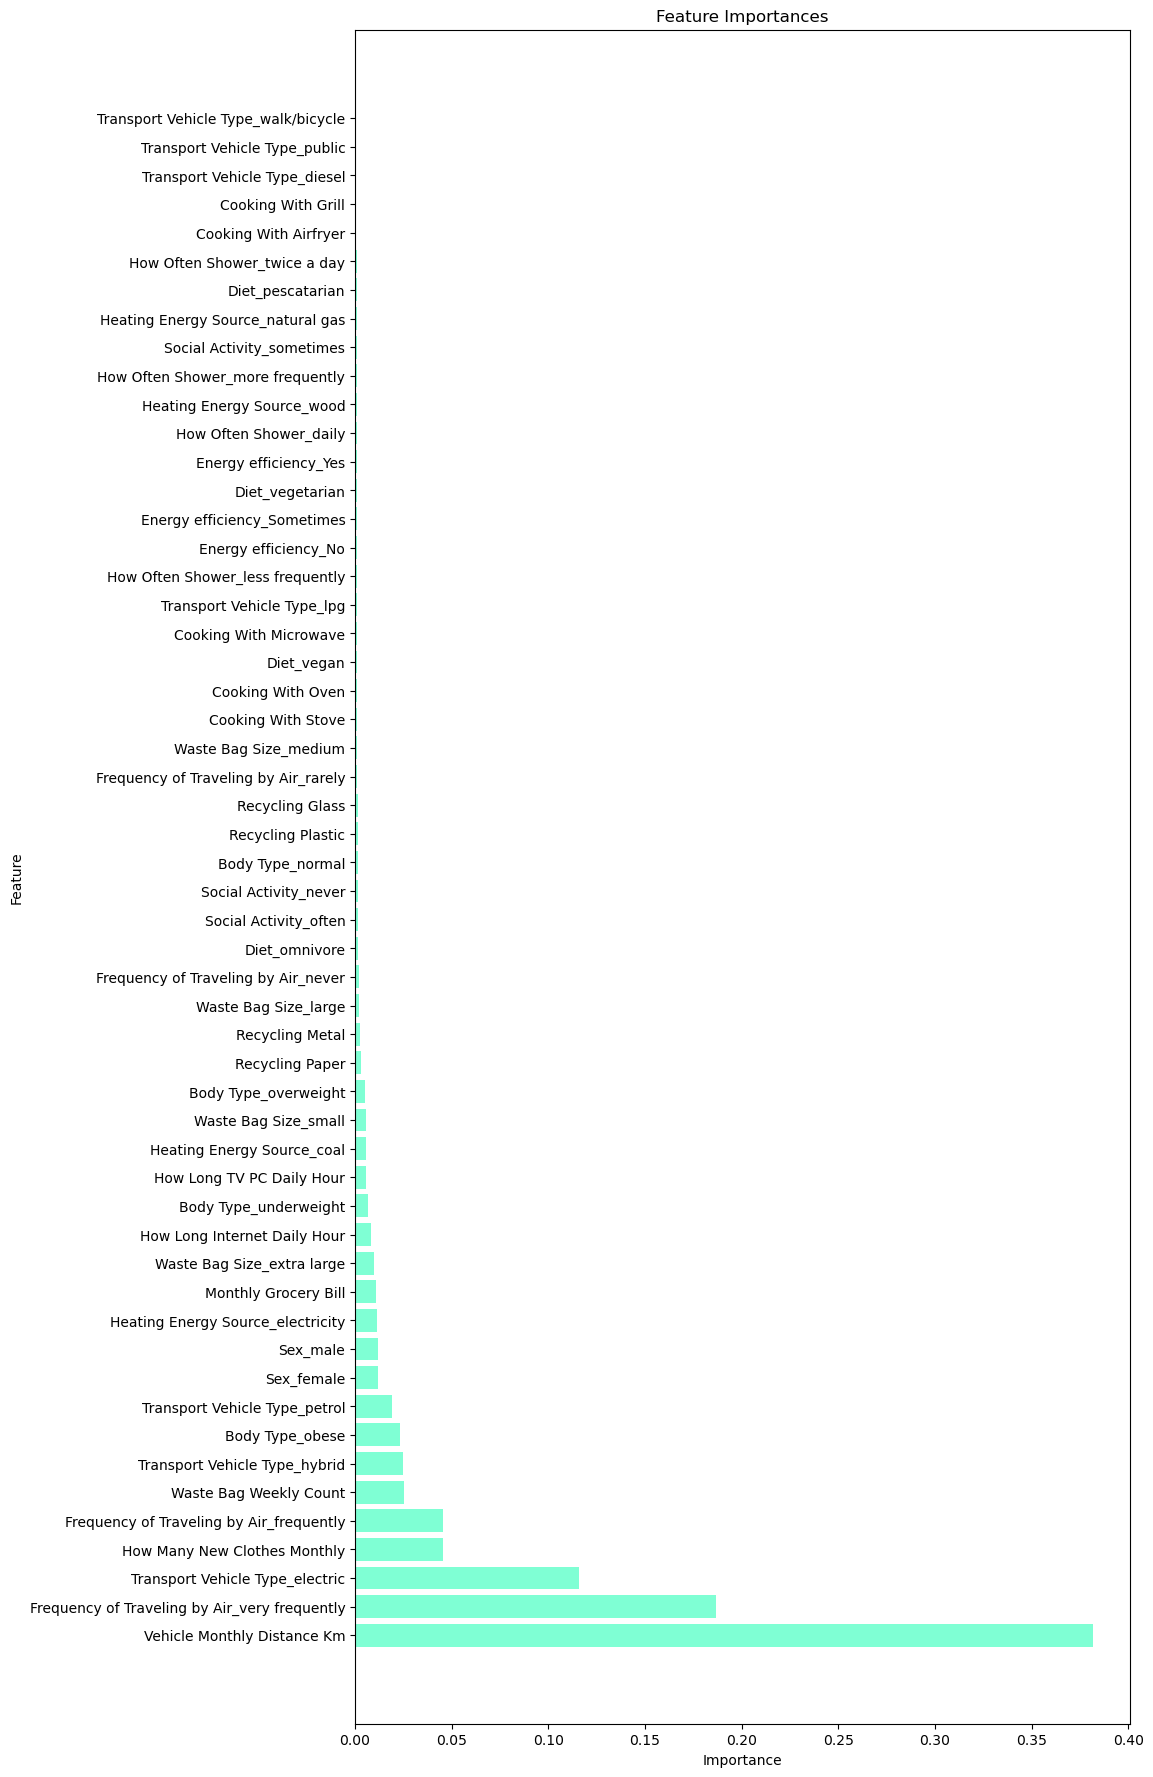

In [ ]:

# Feature importance for random forrest
feature_importances = randomforestregression.feature_importances_

################################################################
# Get the feature names after one-hot encoding. Ella does NOT understand that - chatGTP did the programming
ohe_feature_names = []
for col, transformer, _ in cf.transformers_[:-1]:
    ohe_feature_names.extend(transformer.get_feature_names_out([col]))
all_feature_names = ohe_feature_names + variables_quantitative
################################################################

feature_names = all_feature_names

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualize feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 22))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='Aquamarine')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

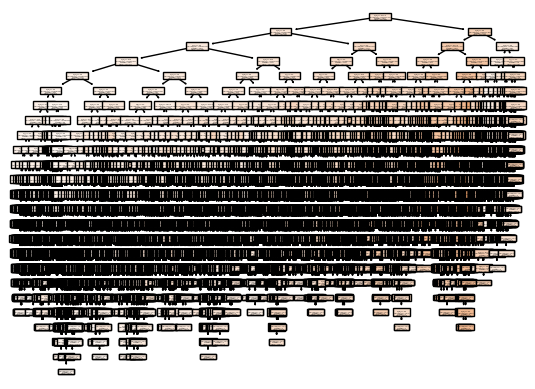

In [16]:
#plotte dicision-tree

#from sklearn.tree import plot_tree
#import matplotlib.pyplot as plt

#plot_tree(decisiontreeregression#, filled=True)
#plt.show()